In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="hmWwD633kHXznyTfDqQS")
project = rf.workspace("fa-ived-iqrcg").project("flood-segmentation-vapdu")
version = project.version(6)
dataset = version.download("png-mask-semantic")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Flood-Segmentation-6 in png-mask-semantic:: 100%|██████████| 376/376 [00:00<00:00, 1364.99it/s]


In [ ]:
from pathlib import Path
import csv

# Change this if your folder is somewhere else
ROOT_DIR = Path("Flood-Segmentation-6")

assert ROOT_DIR.exists(), f"Root dir not found: {ROOT_DIR.resolve()}"
ROOT_DIR


PosixPath('Flood-Segmentation-6')

In [ ]:
def collect_pairs(split_dir: Path):
    """
    Collect (image, mask) pairs for a given split directory.
    Expects:
        image: *.jpg
        mask:  <same_name>_mask.png
    """
    pairs = []

    for img_path in sorted(split_dir.glob("*.jpg")):
        stem = img_path.stem
        mask_name = f"{stem}_mask.png"
        mask_path = split_dir / mask_name

        if not mask_path.exists():
            print(f"[WARN] mask not found for {img_path.name} (expected {mask_name})")
            continue

        pairs.append((img_path, mask_path))

    return pairs


def write_csv(pairs, csv_path: Path, root_dir: Path):
    """
    Write image/mask pairs to CSV with paths relative to root_dir.
    Columns: image_path, mask_path
    """
    csv_path.parent.mkdir(parents=True, exist_ok=True)

    with csv_path.open("w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["image_path", "mask_path"])

        for img_path, mask_path in pairs:
            rel_img = img_path.relative_to(root_dir)
            rel_mask = mask_path.relative_to(root_dir)
            writer.writerow([str(rel_img), str(rel_mask)])

    print(f"[INFO] Wrote {len(pairs)} pairs → {csv_path}")


In [ ]:
splits = ["train", "valid", "test"]

for split in splits:
    split_dir = ROOT_DIR / split

    if not split_dir.exists():
        print(f"[WARN] split folder missing: {split_dir}")
        continue

    print(f"\n[INFO] Processing split: {split}")
    pairs = collect_pairs(split_dir)

    csv_path = ROOT_DIR / f"{split}_pairs.csv"
    write_csv(pairs, csv_path, ROOT_DIR)



[INFO] Processing split: train
[INFO] Wrote 171 pairs → Flood-Segmentation-6/train_pairs.csv

[INFO] Processing split: valid
[INFO] Wrote 9 pairs → Flood-Segmentation-6/valid_pairs.csv

[INFO] Processing split: test
[INFO] Wrote 4 pairs → Flood-Segmentation-6/test_pairs.csv


In [ ]:
!pip install segmentation-models-pytorch albumentations==1.4.3 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.6 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import csv
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

ROOT_DIR = Path("Flood-Segmentation-6")

TRAIN_CSV = ROOT_DIR / "train_pairs.csv"
VAL_CSV   = ROOT_DIR / "valid_pairs.csv"
TEST_CSV  = ROOT_DIR / "test_pairs.csv"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [ ]:
import pandas as pd
from pathlib import Path

ROOT_DIR = Path("Flood-Segmentation-6")

classes_df = pd.read_csv(ROOT_DIR / "train/_classes.csv")
display(classes_df)

NUM_CLASSES = classes_df.shape[0]
print("NUM_CLASSES from _classes.csv:", NUM_CLASSES)


Pixel Value                Class
0             0           background
1             1               Bridge
2             2             Building
3             3              Cottage
4             4                  Dam
5             5             Haystack
6             6                House
7             7   Irrigation Channel
8             8                 Road
9             9               Temple
10           10                 Wall
11           11                  log

NUM_CLASSES from _classes.csv: 12


In [ ]:
import numpy as np
from PIL import Image
import csv

ROOT_DIR = Path("Flood-Segmentation-6")
TRAIN_CSV = ROOT_DIR / "train_pairs.csv"

all_labels = set()

with open(TRAIN_CSV, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        mask_path = ROOT_DIR / row["mask_path"]
        mask = np.array(Image.open(mask_path))

        if mask.ndim == 3:
            mask = mask[:, :, 0]

        unique_vals = np.unique(mask)
        all_labels.update(unique_vals.tolist())

all_labels = sorted(all_labels)
print("Labels present in training masks:", all_labels)

NUM_CLASSES = max(all_labels) + 1
print("NUM_CLASSES inferred from masks:", NUM_CLASSES)


Labels present in training masks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
NUM_CLASSES inferred from masks: 12


In [ ]:
NUM_CLASSES = 12

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

NUM_CLASSES = 12

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES,
)

model = model.to(DEVICE)


DEVICE: cuda


In [ ]:
import segmentation_models_pytorch as smp
from huggingface_hub import hf_hub_download

In [ ]:
# This will download FLAIR-INC_rgb_15cl_resnet34-unet_weights.pth
flair_ckpt_path = hf_hub_download(
    repo_id="IGNF/FLAIR-INC_rgb_15cl_resnet34-unet",
    filename="FLAIR-INC_rgb_15cl_resnet34-unet_weights.pth",
)

flair_ckpt_path



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


FLAIR-INC_rgb_15cl_resnet34-unet_weights(…):   0%|          | 0.00/97.9M [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--IGNF--FLAIR-INC_rgb_15cl_resnet34-unet/snapshots/d8a81bc5bc46357677ba0569e83c4c68d3f78b89/FLAIR-INC_rgb_15cl_resnet34-unet_weights.pth'

In [ ]:
class FloodSegmentationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.samples = []
        self.transform = transform

        with open(csv_file, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                img_path = self.root_dir / row["image_path"]
                mask_path = self.root_dir / row["mask_path"]
                self.samples.append((img_path, mask_path))

        # FLAIR normalization stats (on 0-255 scale)
        self.means = np.array([105.08, 110.87, 101.82], dtype=np.float32)
        self.stds  = np.array([52.17,  45.38,  44.00], dtype=np.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # read full 1024x1024 image and mask
        image = np.array(Image.open(img_path).convert("RGB")).astype(np.float32)  # [H, W, 3], 0-255
        mask = np.array(Image.open(mask_path))

        # if mask has 3 channels but they’re identical, take one
        if mask.ndim == 3:
            mask = mask[:, :, 0]

        # Apply Albumentations transforms if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # FLAIR-style normalization: (x - mean) / std, all in 0-255 space
        image = (image - self.means) / self.stds

        # to tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()

        return image, mask

In [ ]:
BATCH_SIZE = 4
ROOT_DIR = Path("Flood-Segmentation-6")

# Define augmentation transforms
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),
    A.OpticalDistortion(p=0.3),
    A.GridDistortion(p=0.3),
    A.GaussNoise(p=0.2),
])

val_transforms = A.Compose([
    # No heavy augmentations for validation, maybe just resizing if necessary
    # For now, keeping it simple as images are already 1024x1024
])

train_ds = FloodSegmentationDataset(TRAIN_CSV, ROOT_DIR, transform=train_transforms)
val_ds   = FloodSegmentationDataset(VAL_CSV, ROOT_DIR, transform=val_transforms)
test_ds  = FloodSegmentationDataset(TEST_CSV, ROOT_DIR) # No augmentation for test set

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

images, masks = next(iter(train_loader))
print("images:", images.shape)  # [B, 3, 1024, 1024]
print("masks:", masks.shape)    # [B, 1024, 1024]

images: torch.Size([4, 3, 1024, 1024])
masks: torch.Size([4, 1024, 1024])


In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

NUM_CLASSES = 12  # from your dataset

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,   # we'll load from FLAIR
    in_channels=3,
    classes=NUM_CLASSES,
).to(DEVICE)


DEVICE: cuda


In [ ]:
from collections import OrderedDict
import torch

# Load raw checkpoint
raw = torch.load(flair_ckpt_path, map_location="cpu")

if isinstance(raw, dict) and "state_dict" in raw:
    flair_sd = raw["state_dict"]
else:
    flair_sd = raw

print("Example keys from FLAIR checkpoint:")
for i, k in enumerate(flair_sd.keys()):
    print(f"  {i:3d}: {k}")
    if i >= 10:
        break


Example keys from FLAIR checkpoint:
    0: model.seg_model.encoder.conv1.weight
    1: model.seg_model.encoder.bn1.weight
    2: model.seg_model.encoder.bn1.bias
    3: model.seg_model.encoder.bn1.running_mean
    4: model.seg_model.encoder.bn1.running_var
    5: model.seg_model.encoder.bn1.num_batches_tracked
    6: model.seg_model.encoder.layer1.0.conv1.weight
    7: model.seg_model.encoder.layer1.0.bn1.weight
    8: model.seg_model.encoder.layer1.0.bn1.bias
    9: model.seg_model.encoder.layer1.0.bn1.running_mean
   10: model.seg_model.encoder.layer1.0.bn1.running_var


In [ ]:
model_sd = model.state_dict()
flair_prefix = "model.seg_model."

loaded_params = 0
skipped_params = 0

for k in list(model_sd.keys()):
    if k.startswith("encoder.") or k.startswith("decoder."):
        flair_k = flair_prefix + k
        if flair_k in flair_sd:
            model_sd[k] = flair_sd[flair_k]
            loaded_params += 1
        else:
            skipped_params += 1

model.load_state_dict(model_sd)

print(f"Loaded {loaded_params} encoder/decoder params from FLAIR.")
print(f"Skipped {skipped_params} params (no matching key in checkpoint).")


Loaded 276 encoder/decoder params from FLAIR.
Skipped 0 params (no matching key in checkpoint).


In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Phase 1: freeze encoder, warm up decoder + head
for p in model.encoder.parameters():
    p.requires_grad = False

optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
DEVICE


device(type='cuda')

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Loss
criterion = smp.losses.DiceLoss(
    mode="multiclass",
    from_logits=True
)

EPOCHS_FROZEN = 5
EPOCHS_FULL   = 45
TOTAL_EPOCHS  = EPOCHS_FROZEN + EPOCHS_FULL

# Freeze encoder for warm-up
for p in model.encoder.parameters():
    p.requires_grad = False

optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

print("DEVICE:", DEVICE)
print("Warm-up epochs (encoder frozen):", EPOCHS_FROZEN)
print("Full fine-tune epochs (encoder unfrozen):", EPOCHS_FULL)


DEVICE: cuda
Warm-up epochs (encoder frozen): 5
Full fine-tune epochs (encoder unfrozen): 45


In [ ]:
import math
from time import time

def train_one_epoch_verbose(model, loader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    n_samples = len(loader.dataset)
    n_batches = len(loader)

    start_time = time()

    for batch_idx, (images, masks) in enumerate(loader, start=1):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)          # [B, C, H, W]
        loss = criterion(outputs, masks) # masks: [B, H, W] with class ids
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)


        print(
            f"[TRAIN] Epoch {epoch}/{total_epochs} | "
            f"Batch {batch_idx}/{n_batches} | "
            f"Loss: {loss.item():.6f}"
        )

    epoch_loss = running_loss / n_samples
    elapsed = time() - start_time

    print(
        f"[TRAIN] Epoch {epoch}/{total_epochs} DONE | "
        f"Avg Loss: {epoch_loss:.6f} | "
        f"Time: {elapsed:.2f}s"
    )
    print("-" * 80)

    return epoch_loss


@torch.no_grad()
def validate_verbose(model, loader, criterion, device, epoch, total_epochs):
    model.eval()
    running_loss = 0.0
    n_samples = len(loader.dataset)
    n_batches = len(loader)

    start_time = time()

    for batch_idx, (images, masks) in enumerate(loader, start=1):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        running_loss += loss.item() * images.size(0)

        print(
            f"[VALID] Epoch {epoch}/{total_epochs} | "
            f"Batch {batch_idx}/{n_batches} | "
            f"Loss: {loss.item():.6f}"
        )

    epoch_loss = running_loss / n_samples
    elapsed = time() - start_time

    print(
        f"[VALID] Epoch {epoch}/{total_epochs} DONE | "
        f"Avg Loss: {epoch_loss:.6f} | "
        f"Time: {elapsed:.2f}s"
    )
    print("=" * 80)

    return epoch_loss


In [ ]:
best_val_loss = float("inf")
BEST_MODEL_PATH = "flair_unet_14cls_best.pth"

current_epoch = 0

print("===== PHASE 1: ENCODER FROZEN =====")
for i in range(EPOCHS_FROZEN):
    current_epoch += 1
    train_loss = train_one_epoch_verbose(
        model, train_loader, optimizer, criterion, DEVICE,
        epoch=current_epoch, total_epochs=TOTAL_EPOCHS
    )
    val_loss = validate_verbose(
        model, val_loader, criterion, DEVICE,
        epoch=current_epoch, total_epochs=TOTAL_EPOCHS
    )

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f" NEW BEST MODEL (val_loss={val_loss:.6f}) saved to {BEST_MODEL_PATH}")
    else:
        print(f"Best val_loss so far: {best_val_loss:.6f}")

    print("\n\n")


print("===== PHASE 2: FULL FINE-TUNE (ENCODER UNFROZEN) =====")

# Unfreeze encoder
for p in model.encoder.parameters():
    p.requires_grad = True

# New optimizer for all params, smaller LR
optimizer = optim.Adam(model.parameters(), lr=5e-5)

for i in range(EPOCHS_FULL):
    current_epoch += 1
    train_loss = train_one_epoch_verbose(
        model, train_loader, optimizer, criterion, DEVICE,
        epoch=current_epoch, total_epochs=TOTAL_EPOCHS
    )
    val_loss = validate_verbose(
        model, val_loader, criterion, DEVICE,
        epoch=current_epoch, total_epochs=TOTAL_EPOCHS
    )

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"NEW BEST MODEL (val_loss={val_loss:.6f}) saved to {BEST_MODEL_PATH}")
    else:
        print(f"Best val_loss so far: {best_val_loss:.6f}")

    print("\n\n")

print("TRAINING COMPLETE. Best val_loss:", best_val_loss)
print("Best model path:", BEST_MODEL_PATH)


===== PHASE 1: ENCODER FROZEN =====
[TRAIN] Epoch 1/50 | Batch 1/43 | Loss: 0.222122
[TRAIN] Epoch 1/50 | Batch 2/43 | Loss: 0.387638
[TRAIN] Epoch 1/50 | Batch 3/43 | Loss: 0.293509
[TRAIN] Epoch 1/50 | Batch 4/43 | Loss: 0.444914
[TRAIN] Epoch 1/50 | Batch 5/43 | Loss: 0.444206
[TRAIN] Epoch 1/50 | Batch 6/43 | Loss: 0.356277
[TRAIN] Epoch 1/50 | Batch 7/43 | Loss: 0.548780
[TRAIN] Epoch 1/50 | Batch 8/43 | Loss: 0.353820
[TRAIN] Epoch 1/50 | Batch 9/43 | Loss: 0.216016
[TRAIN] Epoch 1/50 | Batch 10/43 | Loss: 0.353260
[TRAIN] Epoch 1/50 | Batch 11/43 | Loss: 0.184675
[TRAIN] Epoch 1/50 | Batch 12/43 | Loss: 0.344531
[TRAIN] Epoch 1/50 | Batch 13/43 | Loss: 0.174277
[TRAIN] Epoch 1/50 | Batch 14/43 | Loss: 0.260975
[TRAIN] Epoch 1/50 | Batch 15/43 | Loss: 0.264491
[TRAIN] Epoch 1/50 | Batch 16/43 | Loss: 0.276339
[TRAIN] Epoch 1/50 | Batch 17/43 | Loss: 0.423350
[TRAIN] Epoch 1/50 | Batch 18/43 | Loss: 0.241614
[TRAIN] Epoch 1/50 | Batch 19/43 | Loss: 0.588539
[TRAIN] Epoch 1/50 | Ba

In [ ]:
torch.save(model, "flair_unet_14cls_best_full.pt")

In [ ]:
from torch.utils.data import DataLoader

# Reuse the same dataset class you used for train/val (same normalization!)
test_ds = FloodSegmentationDataset(VAL_CSV, ROOT_DIR)
test_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

len(test_ds)


9

In [ ]:
BEST_MODEL_PATH = "flair_unet_14cls_best.pth"  # same name we used in training

state = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model = model.to(DEVICE)
model.eval()

print("Loaded best model from:", BEST_MODEL_PATH)


Loaded best model from: flair_unet_14cls_best.pth


In [ ]:
import pandas as pd
import numpy as np

CLASSES_DIR = Path("Flood-Segmentation-6/train")
classes_path = CLASSES_DIR /"_classes.csv"
print(classes_path)
if classes_path.exists():
    classes_df = pd.read_csv(classes_path)
    print(classes_df)
    cols = [c.lower() for c in classes_df.columns]
    print(cols)

    if "name" in cols:
        col_name = classes_df.columns[cols.index("name")]
        class_names = list(classes_df[col_name].astype(str))
    elif " class" in cols:
      print("hello")
      col_name = classes_df.columns[cols.index(" class")]
      class_names = list(classes_df[col_name].astype(str))
    elif "label" in cols:
        col_name = classes_df.columns[cols.index("label")]
        class_names = list(classes_df[col_name].astype(str))
    else:
        class_names = [f"class_{i}" for i in range(NUM_CLASSES)]
else:
    class_names = [f"class_{i}" for i in range(NUM_CLASSES)]

print("Class names:")
for i, n in enumerate(class_names):
    print(f"{i}: {n}")


Flood-Segmentation-6/train/_classes.csv
    Pixel Value                Class
0             0           background
1             1               Bridge
2             2             Building
3             3              Cottage
4             4                  Dam
5             5             Haystack
6             6                House
7             7   Irrigation Channel
8             8                 Road
9             9               Temple
10           10                 Wall
11           11                  log
['pixel value', ' class']
hello
Class names:
0:  background
1:  Bridge
2:  Building
3:  Cottage
4:  Dam
5:  Haystack
6:  House
7:  Irrigation Channel
8:  Road
9:  Temple
10:  Wall
11:  log


In [ ]:
@torch.no_grad()
def evaluate_on_test(model, loader, device, num_classes):
    model.eval()

    # confusion matrix: row = GT, col = Pred
    conf = np.zeros((num_classes, num_classes), dtype=np.int64)

    for batch_idx, (images, masks) in enumerate(loader, start=1):
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)          # [1, C, H, W]
        preds = torch.argmax(logits, dim=1)  # [1, H, W]

        gt = masks.cpu().numpy().reshape(-1)
        pr = preds.cpu().numpy().reshape(-1)

        # combined index = gt * num_classes + pred
        k = gt * num_classes + pr
        hist = np.bincount(k, minlength=num_classes ** 2)
        conf += hist.reshape(num_classes, num_classes)

        if batch_idx % 10 == 0 or batch_idx == len(loader):
            print(f"[TEST] Processed {batch_idx}/{len(loader)} images")

    # per-class IoU
    tp = np.diag(conf)
    fp = conf.sum(axis=0) - tp
    fn = conf.sum(axis=1) - tp
    denom = tp + fp + fn + 1e-7
    iou = tp / denom
    miou = np.mean(iou)

    # overall pixel accuracy
    pixel_acc = tp.sum() / conf.sum()

    print("\n===== TEST METRICS =====")
    print(f"Pixel accuracy: {pixel_acc:.4f}")
    print(f"Mean IoU:       {miou:.4f}\n")
    print("Per-class IoU:")
    for i in range(num_classes):
        print(f"  [{i:2d}] {class_names[i]:20s} IoU = {iou[i]:.4f}")

    return conf, iou, miou, pixel_acc

conf_mat, iou_per_class, miou, pixel_acc = evaluate_on_test(
    model, test_loader, DEVICE, NUM_CLASSES
)


[TEST] Processed 9/9 images

===== TEST METRICS =====
Pixel accuracy: 0.9521
Mean IoU:       0.3801

Per-class IoU:
  [ 0]  background          IoU = 0.9522
  [ 1]  Bridge              IoU = 0.0000
  [ 2]  Building            IoU = 0.6123
  [ 3]  Cottage             IoU = 0.1088
  [ 4]  Dam                 IoU = 0.0000
  [ 5]  Haystack            IoU = 0.8771
  [ 6]  House               IoU = 0.7758
  [ 7]  Irrigation Channel  IoU = 0.4307
  [ 8]  Road                IoU = 0.8045
  [ 9]  Temple              IoU = 0.0000
  [10]  Wall                IoU = 0.0000
  [11]  log                 IoU = 0.0000


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

def mask_to_color(mask, num_classes):
    """
    mask: [H, W] int class ids
    returns: [H, W, 3] float32, range 0-1
    """
    # Use plt.get_cmap to avoid deprecation warning
    cmap = plt.get_cmap('tab20', num_classes)
    colored = cmap(mask % num_classes)[..., :3]  # drop alpha
    return colored

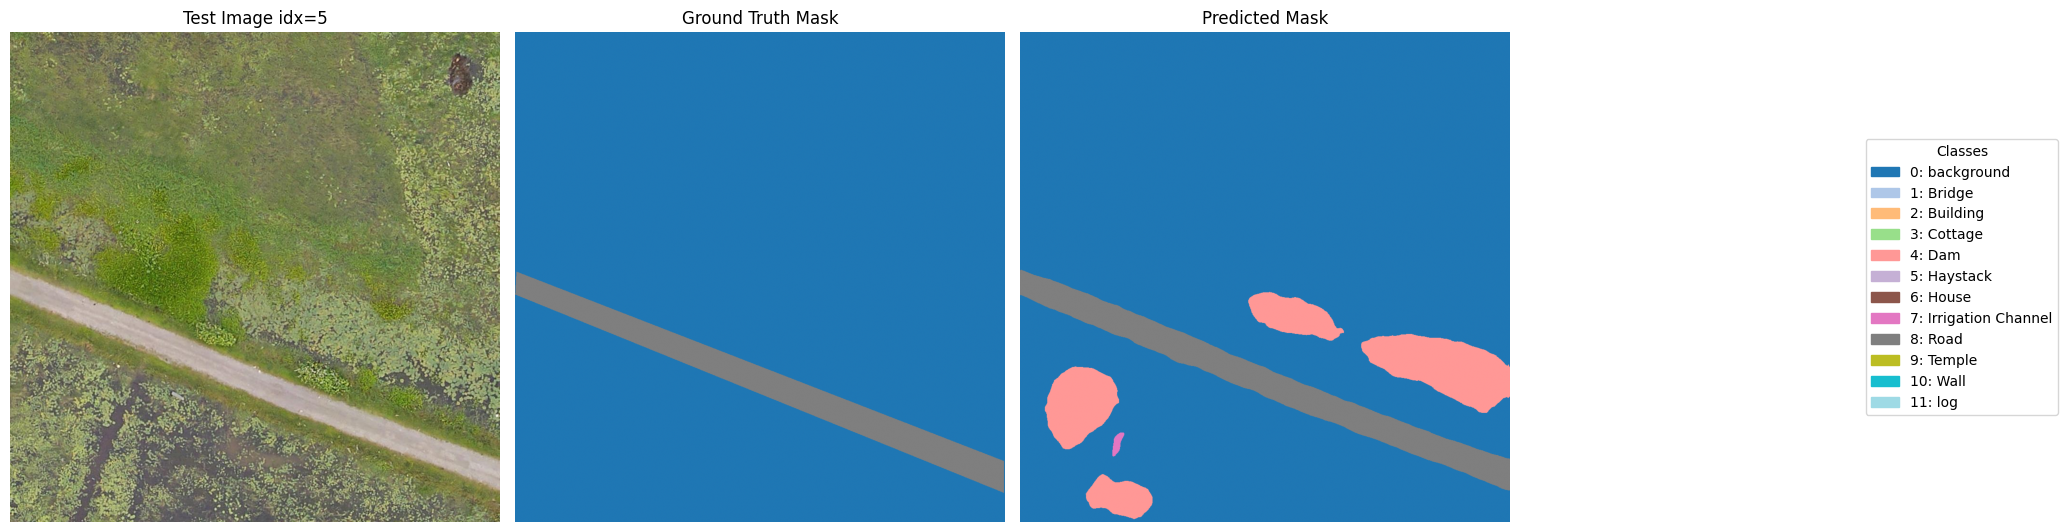

GT labels present:    {0: ' background', 8: ' Road'}
Pred labels present:  {0: ' background', 4: ' Dam', 7: ' Irrigation Channel', 8: ' Road'}
----------------------------------------------------------------------------------------------------


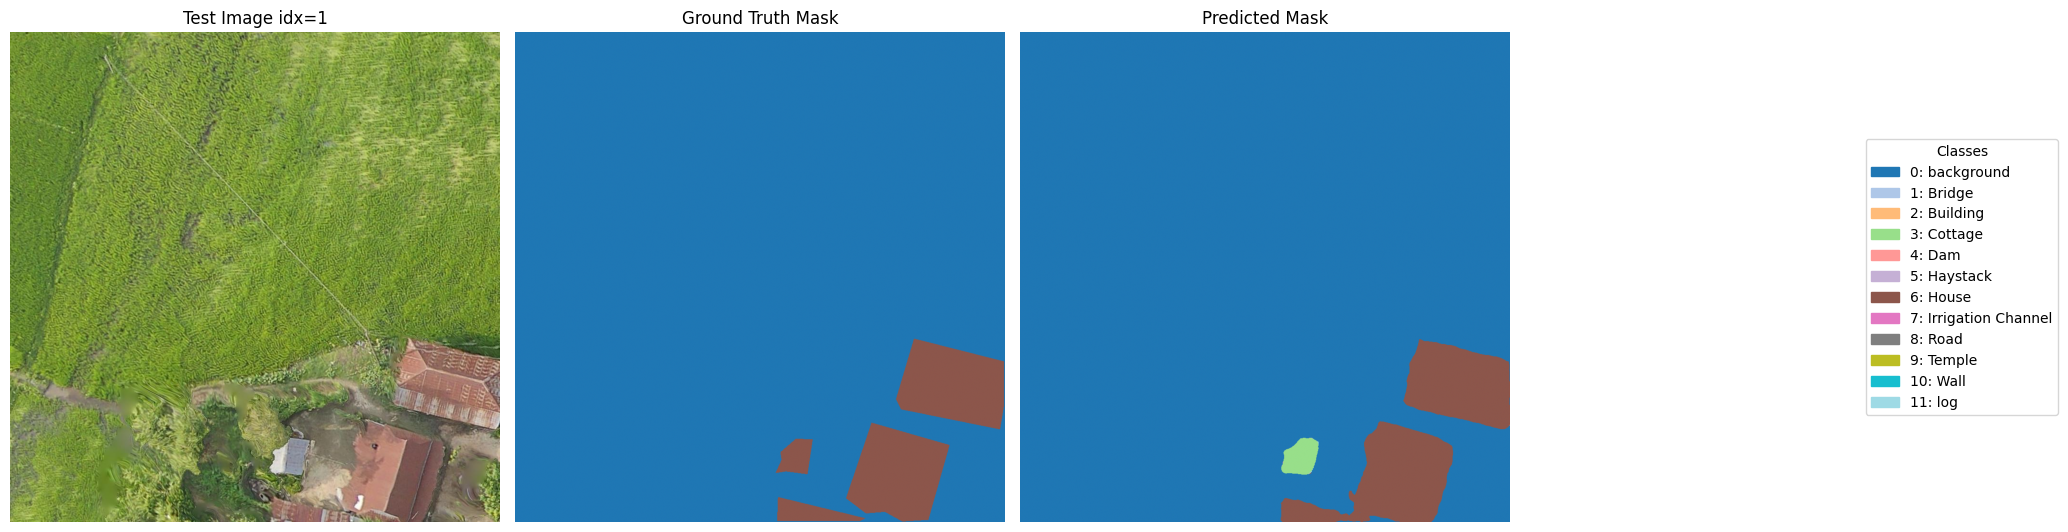

GT labels present:    {0: ' background', 6: ' House'}
Pred labels present:  {0: ' background', 3: ' Cottage', 4: ' Dam', 6: ' House', 7: ' Irrigation Channel', 11: ' log'}
----------------------------------------------------------------------------------------------------


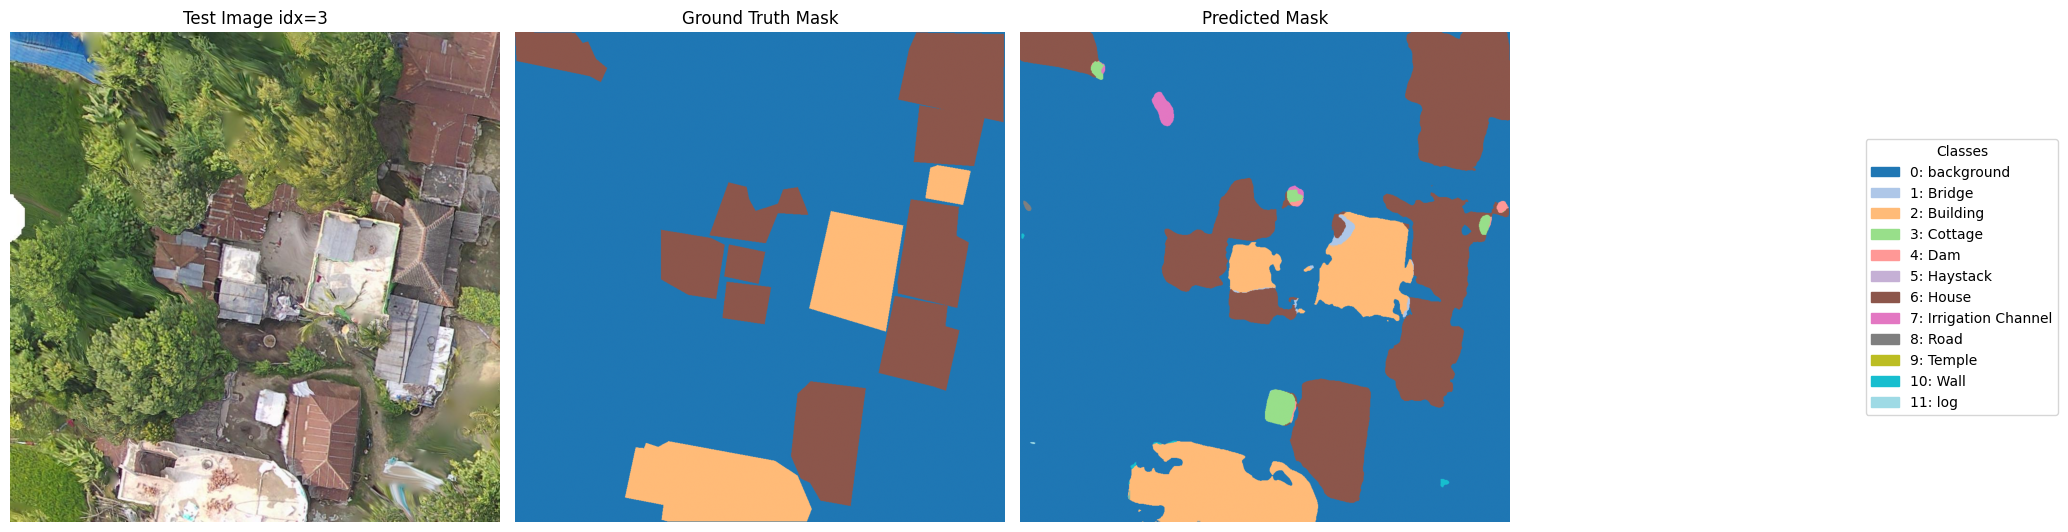

GT labels present:    {0: ' background', 2: ' Building', 6: ' House'}
Pred labels present:  {0: ' background', 1: ' Bridge', 2: ' Building', 3: ' Cottage', 4: ' Dam', 5: ' Haystack', 6: ' House', 7: ' Irrigation Channel', 8: ' Road', 10: ' Wall', 11: ' log'}
----------------------------------------------------------------------------------------------------


In [ ]:
import random
import matplotlib.patches as mpatches # Import mpatches for custom legend handles

def unnormalize_image(image_tensor):
    """
    image_tensor: [3, H, W], normalized with FLAIR stats on 0-255.
    returns: [H, W, 3] in [0,1]
    """
    means = np.array([105.08, 110.87, 101.82], dtype=np.float32)
    stds  = np.array([52.17,  45.38,  44.00], dtype=np.float32)

    img = image_tensor.permute(1, 2, 0).cpu().numpy()  # [H,W,3]
    img = img * stds + means
    img = np.clip(img / 255.0, 0, 1)
    return img


@torch.no_grad()
def show_test_sample(model, dataset, idx=None):
    model.eval()
    if idx is None:
        idx = random.randint(0, len(dataset)-1)

    image, mask = dataset[idx]        # image: [3,H,W] (normalized), mask: [H,W]
    logits = model(image.unsqueeze(0).to(DEVICE))
    pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

    img_rgb = unnormalize_image(image)
    gt_color   = mask_to_color(mask.numpy(), NUM_CLASSES)
    pred_color = mask_to_color(pred, NUM_CLASSES)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title(f"Test Image idx={idx}")
    axs[0].axis("off")

    axs[1].imshow(gt_color)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_color)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    # Create a legend mapping colors to class names
    handles = []
    cmap = plt.get_cmap('tab20', NUM_CLASSES)
    for i in range(NUM_CLASSES):
        label = class_names[i]
        # Handle cases where class_names might have leading/trailing spaces
        label = label.strip()
        color = cmap(i)
        handles.append(mpatches.Patch(color=color, label=f'{i}: {label}'))

    # Place the legend outside the subplots
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5), title="Classes")

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
    plt.show()

    # Also print some label info for sanity
    gt_labels = np.unique(mask.numpy())
    pred_labels = np.unique(pred)
    print("GT labels present:   ", {int(l): class_names[int(l)] for l in gt_labels if int(l) < len(class_names)})
    print("Pred labels present: ", {int(l): class_names[int(l)] for l in pred_labels if int(l) < len(class_names)})

# Example: show 3 random test samples
for _ in range(3):
    show_test_sample(model, test_ds)
    print("-" * 100)

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
import torch

def preprocess_custom_image(img_path, expected_size=(1024, 1024)):
    """
    img_path: path to RGB image
    expected_size: (H, W); if different, image will be resized.
    Returns: torch.Tensor [1, 3, H, W] on DEVICE
    """
    img_path = Path(img_path)
    assert img_path.exists(), f"Image not found: {img_path}"

    image = Image.open(img_path).convert("RGB")

    # If your tiles are exactly 1024x1024 already, you can comment this out
    if image.size != (expected_size[1], expected_size[0]):  # PIL: (W,H)
        print(f"[INFO] Resizing from {image.size} to {expected_size[::-1]}")
        image = image.resize((expected_size[1], expected_size[0]), Image.BILINEAR)

    image = np.array(image).astype(np.float32)  # [H,W,3] 0-255

    # FLAIR normalization
    means = np.array([105.08, 110.87, 101.82], dtype=np.float32)
    stds  = np.array([52.17,  45.38,  44.00], dtype=np.float32)
    image = (image - means) / stds

    tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()  # [1,3,H,W]
    tensor = tensor.to(DEVICE)
    return tensor


In [ ]:
@torch.no_grad()
def infer_custom_image(img_path):
    """
    img_path: path to image
    Returns:
        pred_mask_np: [H, W] int class ids (on CPU)
    """
    model.eval()
    tensor = preprocess_custom_image(img_path)      # [1,3,H,W]
    logits = model(tensor)                          # [1,C,H,W]
    pred = torch.argmax(logits, dim=1).squeeze(0)   # [H,W]
    pred_np = pred.cpu().numpy().astype(np.int32)
    return pred_np


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

def mask_to_color(mask, num_classes):
    # Use plt.get_cmap to avoid deprecation warning
    cmap = plt.get_cmap('tab20', num_classes)
    colored = cmap(mask % num_classes)[..., :3]   # [H,W,3]
    return colored

def load_raw_rgb(img_path, expected_size=(1024, 1024)):
    img = Image.open(img_path).convert("RGB")
    if img.size != (expected_size[1], expected_size[0]):
        img = img.resize((expected_size[1], expected_size[0]), Image.BILINEAR)
    return np.array(img).astype(np.float32) / 255.0

In [ ]:
def show_custom_prediction(img_path):
    pred_mask = infer_custom_image(img_path)
    rgb = load_raw_rgb(img_path, expected_size=pred_mask.shape)

    pred_color = mask_to_color(pred_mask, NUM_CLASSES)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(rgb)
    axs[0].set_title("Input image")
    axs[0].axis("off")

    axs[1].imshow(pred_color)
    axs[1].set_title("Predicted mask")
    axs[1].axis("off")

    # Create a legend mapping colors to class names
    handles = []
    cmap = plt.get_cmap('tab20', NUM_CLASSES)
    for i in range(NUM_CLASSES):
        label = class_names[i]
        # Handle cases where class_names might have leading/trailing spaces
        label = label.strip()
        color = cmap(i)
        handles.append(mpatches.Patch(color=color, label=f'{i}: {label}'))

    # Place the legend outside the subplots
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5), title="Classes")

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
    plt.show()

    # Print which classes are present
    uniq = np.unique(pred_mask)
    print("Predicted labels present:")
    for c in uniq:
        cname = class_names[c].strip() if c < len(class_names) else f"class_{c}"
        print(f"  {c}: {cname}")

[INFO] Resizing from (612, 459) to (1024, 1024)


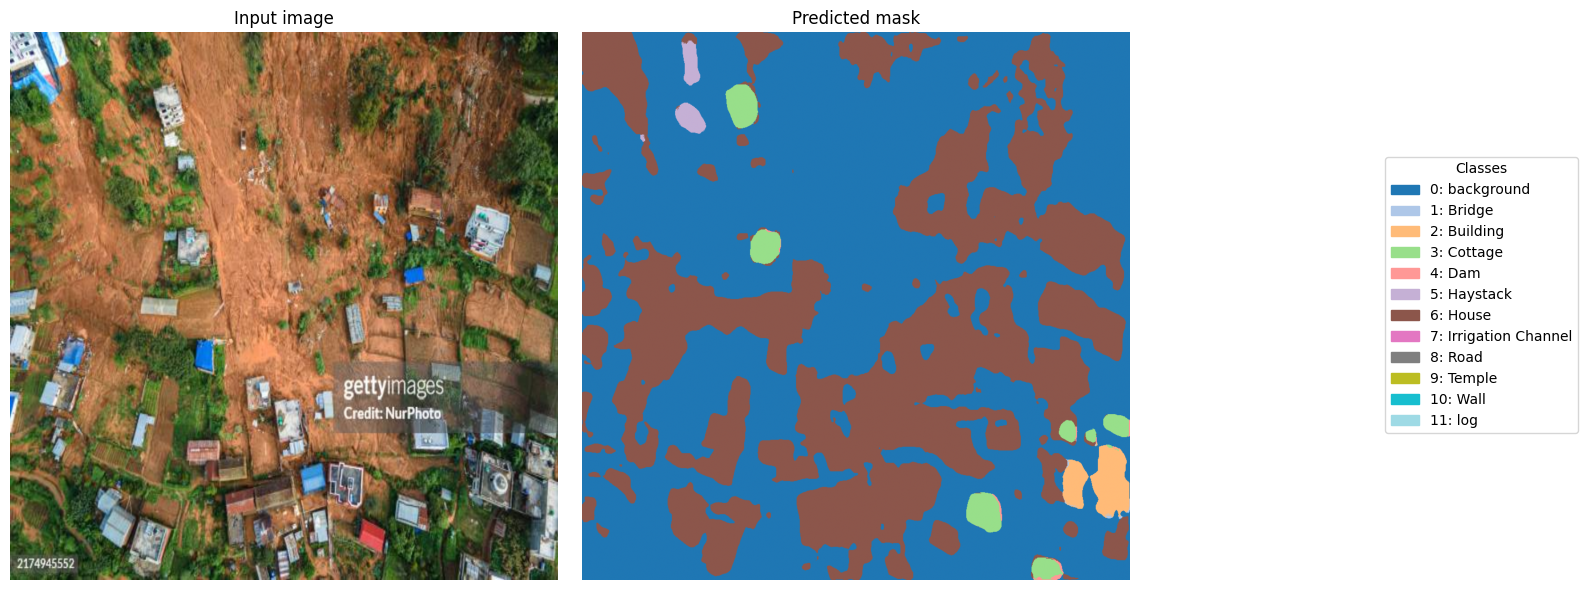

Predicted labels present:
  0: background
  1: Bridge
  2: Building
  3: Cottage
  4: Dam
  5: Haystack
  6: House
  7: Irrigation Channel
  11: log


In [ ]:
CUSTOM_IMG_PATH = "gettyimages-2174945552-612x612.jpg"  # <- change this
show_custom_prediction(CUSTOM_IMG_PATH)
